In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy import interpolate
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import interp2d, griddata
from scipy import optimize
from scipy import interpolate
from scipy.optimize import curve_fit


In [6]:
data = pd.read_csv('data_fs.dat', delim_whitespace=True, decimal=",")
r=data[data['y']==0]
r

,id,x,y,z,fwhm_x,fwhm_y,e,tilt,co_max,cx_max,xpd,sub_spill,main_spill
6,145,-0.321458,0.0,40,0.355884,0.375494,1.055103,0.000000,54.25,"11,32",42.93,0.000503,0.004118
19,416,-0.268863,0.0,30,0.354455,0.358904,1.012551,-0.000001,54.49,"9,62",44.86,0.000308,0.005028
32,687,-0.215898,0.0,20,0.347213,0.348661,1.004172,-0.000007,54.73,"8,47",46.25,0.000207,0.004759
45,959,-0.162382,0.0,15,0.345518,0.345394,1.000358,-0.000137,54.81,"6,16",48.65,0.000147,0.004534
58,1230,-0.108701,0.0,5,0.343938,0.342320,1.004728,-0.000003,54.88,"2,32",52.56,0.000124,0.005445
71,1502,-0.054524,0.0,0,0.342923,0.342212,1.002077,0.000002,54.90,"-3,69",58.59,0.000117,0.005589
84,1775,0.000000,0.0,0,0.342795,0.342548,1.000721,-0.000070,54.89,*****,68.77,0.000122,0.005870
97,2048,0.054780,0.0,0,0.343377,0.342782,1.001736,-0.000002,54.88,"-2,55",57.42,0.000142,0.006610
110,2322,0.109725,0.0,5,0.343244,0.343627,1.001117,-0.000018,54.87,"2,63",52.24,0.000172,0.007195
123,2597,0.164679,0.0,15,0.346530,0.347260,1.002104,0.000056,54.75,"6,45",48.30,0.000212,0.007441


# Sampling of the data

This plot shows the placement of the data points in 3D space

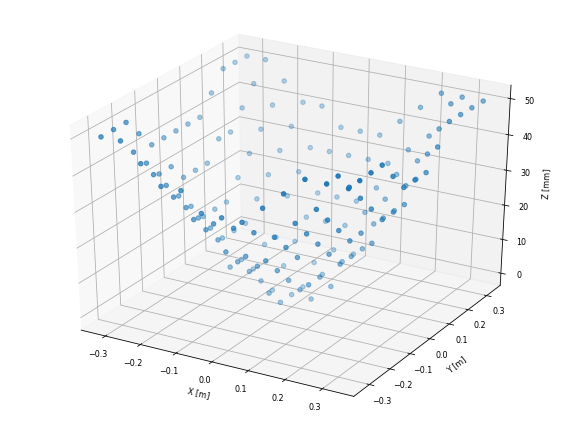

In [148]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data["x"], data["y"], data["z"])

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [mm]')
plt.rcParams.update({'font.size': 8})
fig.tight_layout()

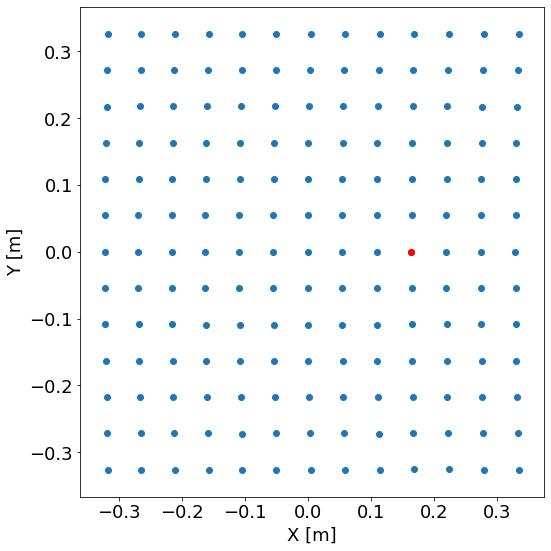

In [11]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

ax.scatter(data["x"], data["y"])
ax.scatter(0.164679, 0, color='r')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
plt.rcParams.update({'font.size': 18})
fig.tight_layout()
plt.savefig("GrigliaPunti", dpi=400)

This shows a contour plot of the previous 3D plot

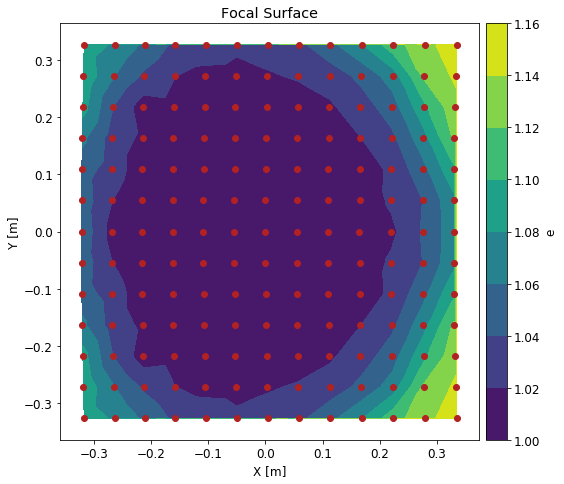

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = ax.tricontourf(data["x"], data["y"], data["e"])
ax.set_aspect("equal")
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_title("Focal Surface")
ax.scatter(data["x"], data["y"], color="firebrick")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

cbar = fig.colorbar(g, cax=cax)
cbar.set_label("e")
fig.tight_layout()
plt.rcParams.update({'font.size': 12})
plt.savefig("ContourPlot_e.pdf", dpi=400)

Let's investigate the dependency of ellipticity on the position on the focal plane. We use `scipy.interpolate` to build two objects:

- a `e_func` object, which behaves like a function and associates a pair `(x, y)` to an (interpolated) ellipticity;
- a `e_grid` matrix, which contains a linear interpolation of the ellipticity for all the pairs `(x, y)` we have read above from the data file.

In [6]:
def linspace(vec, n):
    return np.linspace(np.min(vec), np.max(vec), n)

xpoints = linspace(data["x"], 100)
ypoints = linspace(data["y"], 100)

e_func = interp2d(data["x"], data["y"], data["e"], kind="linear")

e_grid = griddata((data["x"], data["y"]), data["e"], (xpoints[None, :], ypoints[:, None]), method="linear")

You can see that `e_func` behaves like a function

In [7]:
e_func(-0.316965, 0.326756)

array([1.091361])

In [12]:
e_grid.size

10000

Let's plot the ellipticity on the X-Y plane, marking the data points with red dots:

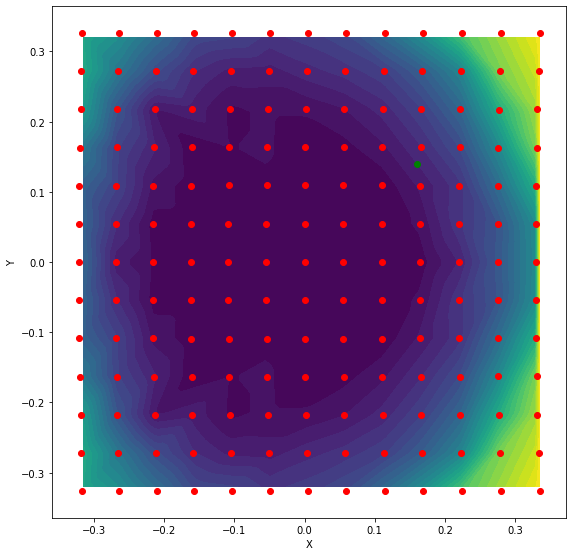

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

axes.contourf(xpoints, ypoints, e_grid, 30)
axes.scatter(data["x"], data["y"], color="red")
axes.scatter([0.16], [0.14], color="green")
axes.set_aspect("equal")
axes.set_xlabel("X")
axes.set_ylabel("Y")
fig.tight_layout()

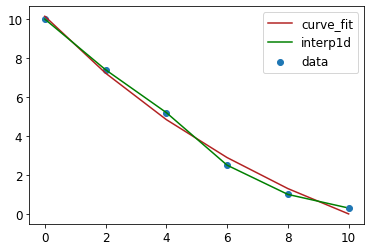

In [10]:
import numpy as np
import matplotlib.pylab as plt
from scipy import interpolate
from scipy import optimize

np.random.seed(0)
x_data = np.linspace(0, 10, num=6)
y_data = [10, 7.4, 5.2, 2.5, 1, 0.3]

#curve_fit
def test_func(x, a, b, c, d):
    return a**((b*x)+c)+d

popt, pcov = optimize.curve_fit(test_func, x_data, y_data)

#interp1d
f = interpolate.interp1d(x_data, y_data)
xnew = np.arange(0, 10, 0.1)
ynew = f(xnew)

#plot
plt.figure(figsize=(6, 4))
plt.scatter(x_data, y_data, label='data')
#plot curve_fit
plt.plot(x_data, test_func(x_data, *popt), label='curve_fit', color='firebrick')
#plot interp1d
plt.plot(xnew, ynew, label='interp1d', color='green')

plt.legend(loc='best')
plt.savefig("EsempioInterpolazione.pdf", dpi=400)

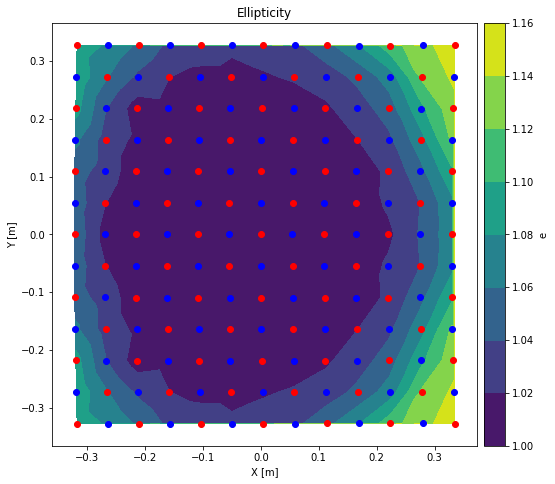

In [4]:
import functions as fc
data = pd.read_csv('data_fs.dat', delim_whitespace=True, decimal=",")
fc.add_bool(data)
data_int = data[data['check'] == True]
data_check = data[data['check'] == False]


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = ax.tricontourf(data["x"], data["y"], data["e"])
ax.set_aspect("equal")
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_title("Ellipticity")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

pt_int = ax.scatter(data_int["x"], data_int["y"], color="red")
pt_check = ax.scatter(data_check["x"], data_check["y"], color="b")
#plt.legend((pt_int, pt_check), ('Interpolation', 'Check'), scatterpoints=1, fontsize=10)

cbar = fig.colorbar(g, cax=cax)
cbar.set_label("e")
fig.tight_layout()
plt.rcParams.update({'font.size': 16})
fig.tight_layout()

plt.savefig("ContourPlot_e.pdf", dpi=400)

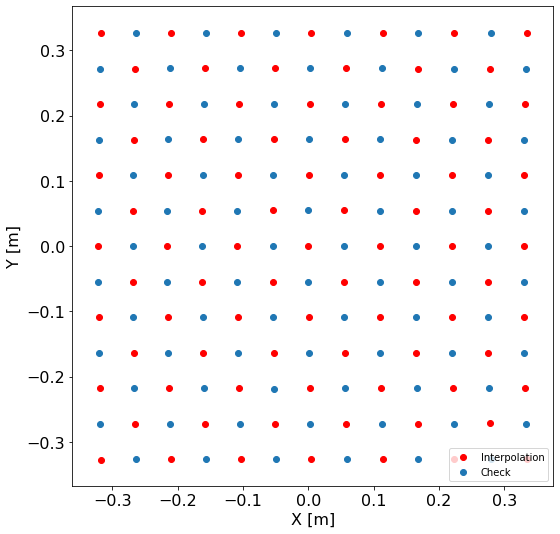

In [13]:
fig = plt.figure(figsize=(8, 8))


ax = fig.add_subplot(111)
pt_int = ax.scatter(data_int["x"], data_int["y"], color="r")
pt_check = ax.scatter(data_check["x"], data_check["y"], color="tab:blue")
ax.set_aspect("equal")
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
plt.legend((pt_int, pt_check), ('Interpolation', 'Check'), loc=4 ,scatterpoints=1, fontsize=10)
fig.tight_layout()
plt.rcParams.update({'font.size': 16})
plt.savefig("GrigliaRossoBlu.pdf", dpi=400)

In [169]:
data_prob = data[data["y"]>0.3]

In [170]:
data_prob = data_prob[data["check"]==False]
data_prob

/Users/eleonoragatti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,id,x,y,z,fwhm_x,fwhm_y,e,tilt,co_max,cx_max,xpd,sub_spill,main_spill,check
13,294,-0.263845,0.326474,50,0.391116,0.363218,1.076807,-42.778528,53.95,"13,31",40.64,0.001201,0.004901,False
39,838,-0.157307,0.326597,40,0.369303,0.356781,1.035098,-20.322200,54.29,"11,71",42.58,0.000700,0.005969,False
65,1383,-0.049570,0.326640,35,0.361194,0.352552,1.024513,9.861373,54.46,"10,39",44.08,0.000528,0.006205,False
91,1929,0.059248,0.326600,35,0.363217,0.350828,1.035313,30.863368,54.45,"10,59",43.86,0.000526,0.006561,False
117,2477,0.168829,0.326094,45,0.379879,0.352218,1.078534,-135.039205,54.22,"11,48",42.74,0.000648,0.007589,False
143,3024,0.279492,0.326170,50,0.350854,0.397679,1.133462,-34.367081,54.02,"13,48",40.54,0.000950,0.009472,False


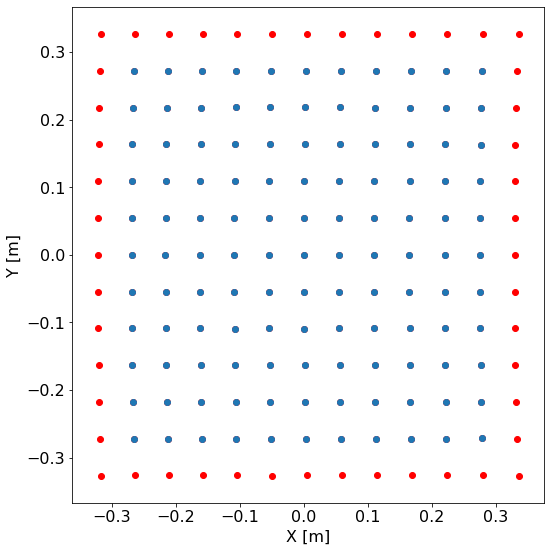

In [12]:
mask = (abs(data["x"]) < 0.3) & (abs(data["y"]) < 0.3)
data_mask = data[mask]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

ax.scatter(data["x"], data["y"], color="r")
ax.scatter(data_mask["x"], data_mask["y"], color="tab:blue")
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
plt.rcParams.update({'font.size': 18})
fig.tight_layout()
plt.savefig("PuntiMask.pdf", dpi=600)